In [ ]:
%matplotlib inline

In [1]:
from linescanning import (
    prf,
    pycortex,
)
import numpy as np
from scipy.stats import pearsonr
import os
import cortex as cx
import matplotlib.pyplot as plt
import nibabel as nib

opd = os.path.dirname
opj = os.path.join

## <h1> Retinotopical analysis for Memantine Project </h1>
This notebook is used to plot polar angle and eccentricity maps in each of the two experimental conditions for one individual subject. It requires you to already have a flatmap available for this subject.

In [236]:
conditions = {
    'sub-001': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-002': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-003': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-004': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-005': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-007': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-008': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-010': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-012': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-013': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-015': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-016': {'memantine': 'ses-2', 'placebo': 'ses-3'}
}

sub='sub-016'
model='norm'
deriv='/data1/projects/Meman1/projects/pilot/derivatives'
finalrois= opj(deriv, 'freesurfer',sub, 'customlabel', 'roidrawing', 'final')
design = prf.read_par_file(opj(deriv, 'prf', sub, 'design_task-2R.mat'))

# Load data placebo
dataplacebo = np.load(opj(deriv, 'prf', sub, conditions[sub]['placebo'], f'{sub}_{conditions[sub]["placebo"]}_task-2R_hemi-LR_desc-avg_bold.npy'))

# Initialize empty array of parameters with the appropriate shape
paramsplacebo_norm = np.zeros(shape=(dataplacebo.shape[1], 12))

# Load data memantine
datamemantine = np.load(opj(deriv, 'prf', sub, conditions[sub]['memantine'], f'{sub}_{conditions[sub]["memantine"]}_task-2R_hemi-LR_desc-avg_bold.npy'))

# Initialize empty array of parameters with the appropriate shape
paramsmemantine_norm = np.zeros(shape=(datamemantine.shape[1], 12))

minr2=0.1
minecc=0.5 #The minimum
maxecc=4.5 #The maximum eccentricity you want to use

outputdata = opj('/data1/projects/Meman1/projects/pilot/code/floris/output', sub)

In [237]:
#Load V1 vertices from left hemisphere, together with the number of vertices in the left hemisphere so indexing for right hemisphere works appropriately; the .label files start from 0 and work per hemisphere, whereas Inkscape merges the two hemispheres together.
V1_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V1.label'))
V2_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V2.label'))
V3_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V3.label'))

all_lh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'lh.inflated'))

#Load V1 vertices from right hemisphere. 
V1_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V1.label'))
V2_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V2.label'))
V3_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V3.label'))

all_rh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'rh.inflated'))

# Get the right indices for the right hemisphere by adding the number of vertices in left hemisphere to the ROI indices for the right hemisphere.
V1_rh = V1_rh + len(all_lh[0])
V2_rh = V2_rh + len(all_lh[0])
V3_rh = V3_rh + len(all_lh[0])

#Concatenate the 2 and sort them such that they are in the right order
V1_vertices = np.sort(np.concatenate([V1_lh, V1_rh]))
V2_vertices = np.sort(np.concatenate([V2_lh, V2_rh]))
V3_vertices = np.sort(np.concatenate([V3_lh, V3_rh]))

roi_vertices = np.sort(np.concatenate([V1_vertices, V2_vertices, V3_vertices]))

In [238]:
for i in range(20):
    roivertices = np.load(opj(outputdata, 'roivertices', f'roivertices_{sub}_slice-{i}.npy'))
    paramssplac= np.load(opj(outputdata, 'fits', f'{sub}_{conditions[sub]["placebo"]}_task-2R_model-norm_stage-iter_desc-prfparams_slice-{i}.npy'))
    paramssmem = np.load(opj(outputdata, 'fits', f'{sub}_{conditions[sub]["memantine"]}_task-2R_model-norm_stage-iter_desc-prfparams_slice-{i}.npy'))
    for index, roivertex in enumerate(roivertices):
        paramsplacebo_norm[roivertex] = paramssplac[index]
        paramsmemantine_norm[roivertex] = paramssmem[index]

In [239]:
# initialize empty model for placebo
norm_plac= prf.pRFmodelFitting(
    dataplacebo.T,
    design_matrix=design,
    TR=1.5,                     # default
    model=model,              # default, can be 'gauss', 'css', 'dog', 'norm'
    stage="iter",               # default
    verbose=True,               # keep track of what we're doing,
    fix_bold_baseline=True      # fix the BOLD baseline at 0
)

# load params, also load prf_obj
norm_plac.load_params(paramsplacebo_norm, model=model, stage="iter")

# initialize empty model for placebo
norm_mem= prf.pRFmodelFitting(
    datamemantine.T,
    design_matrix=design,
    TR=1.5,                     # default
    model=model,              # default, can be 'gauss', 'css', 'dog', 'norm'
    stage="iter",               # default
    verbose=True,               # keep track of what we're doing,
    fix_bold_baseline=True      # fix the BOLD baseline at 0
)

# load params, also load prf_obj
norm_mem.load_params(paramsmemantine_norm, model=model, stage="iter")

Design has 5 more volumes than timecourses, trimming from beginning of design to (100, 100, 220)
Reading settings from '/data1/projects/Meman1/projects/pilot/code/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
---------------------------------------------------------------------------------------------------

Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0] (fit=True)
Using constraint(s): ['tc', 'tc']
Inserting parameters from <class 'numpy.ndarray'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f0f124ceeb0>
Design has 5 more volumes than timecourses, trimming from beginning of design to (100, 100, 220)
Reading settings from '/data1/projects/Meman1/projects/pilot/code/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these impor

In [240]:
parameters_plac_df = prf.Parameters(params=getattr(norm_plac, f"norm_iter"), model='norm').to_df()
parameters_mem_df = prf.Parameters(params=getattr(norm_mem, f"norm_iter"), model='norm').to_df()

In [241]:
from dag_prf_utils.cmap_functions import dag_make_custom_cmap
import json

cmapfile = '/home/tijhuis/Downloads/dag_prf_utils/dag_prf_utils/cmaps.json'

with open(cmapfile, 'r') as f:
    cmap_data = json.load(f)

custom_cmap_marco_pol = dag_make_custom_cmap(col_list=cmap_data['marco_pol']['col_list'], col_steps=cmap_data['marco_pol']['col_steps'])

In [242]:
r2_v_plac = pycortex.Vertex2D_fix(
    parameters_plac_df.r2,
    parameters_plac_df.r2,
    subject=sub,
    cmap="magma",
    vmax1=round(parameters_plac_df.r2.max(),2),
    vmin2=0.1,
    vmax2=0.5)

# make object for eccentricity
ecc_v_plac = pycortex.Vertex2D_fix(
    parameters_plac_df.ecc,
    parameters_plac_df.r2,
    subject=sub,
    cmap="nipy_spectral",
    vmax1=5,
    vmin2=0.1,
    vmax2=0.5)

# make object for polar angle
polar_v_plac = pycortex.Vertex2D_fix(
    parameters_plac_df.polar,
    parameters_plac_df.r2,
    subject=sub,
    cmap=custom_cmap_marco_pol,
    vmin1=-np.pi,
    vmax1=np.pi,
    vmin2=0.1,                
    vmax2=0.5)

r2_v_mem = pycortex.Vertex2D_fix(
    parameters_mem_df.r2,
    parameters_mem_df.r2,
    subject=sub,
    cmap="magma",
    vmax1=round(parameters_mem_df.r2.max(),2),
    vmin2=0.1,
    vmax2=0.5)

# make object for eccentricity
ecc_v_mem = pycortex.Vertex2D_fix(
    parameters_mem_df.ecc,
    parameters_mem_df.r2,
    subject=sub,
    cmap="nipy_spectral",
    vmax1=5,
    vmin2=0.1,
    vmax2=0.5)

# make object for polar angle
polar_v_mem = pycortex.Vertex2D_fix(
    parameters_mem_df.polar,
    parameters_mem_df.r2,
    subject=sub,
    cmap=custom_cmap_marco_pol,
    vmin1=-np.pi,
    vmax1=np.pi,
    vmin2=0.1,                
    vmax2=0.5)

In [243]:
%matplotlib inline

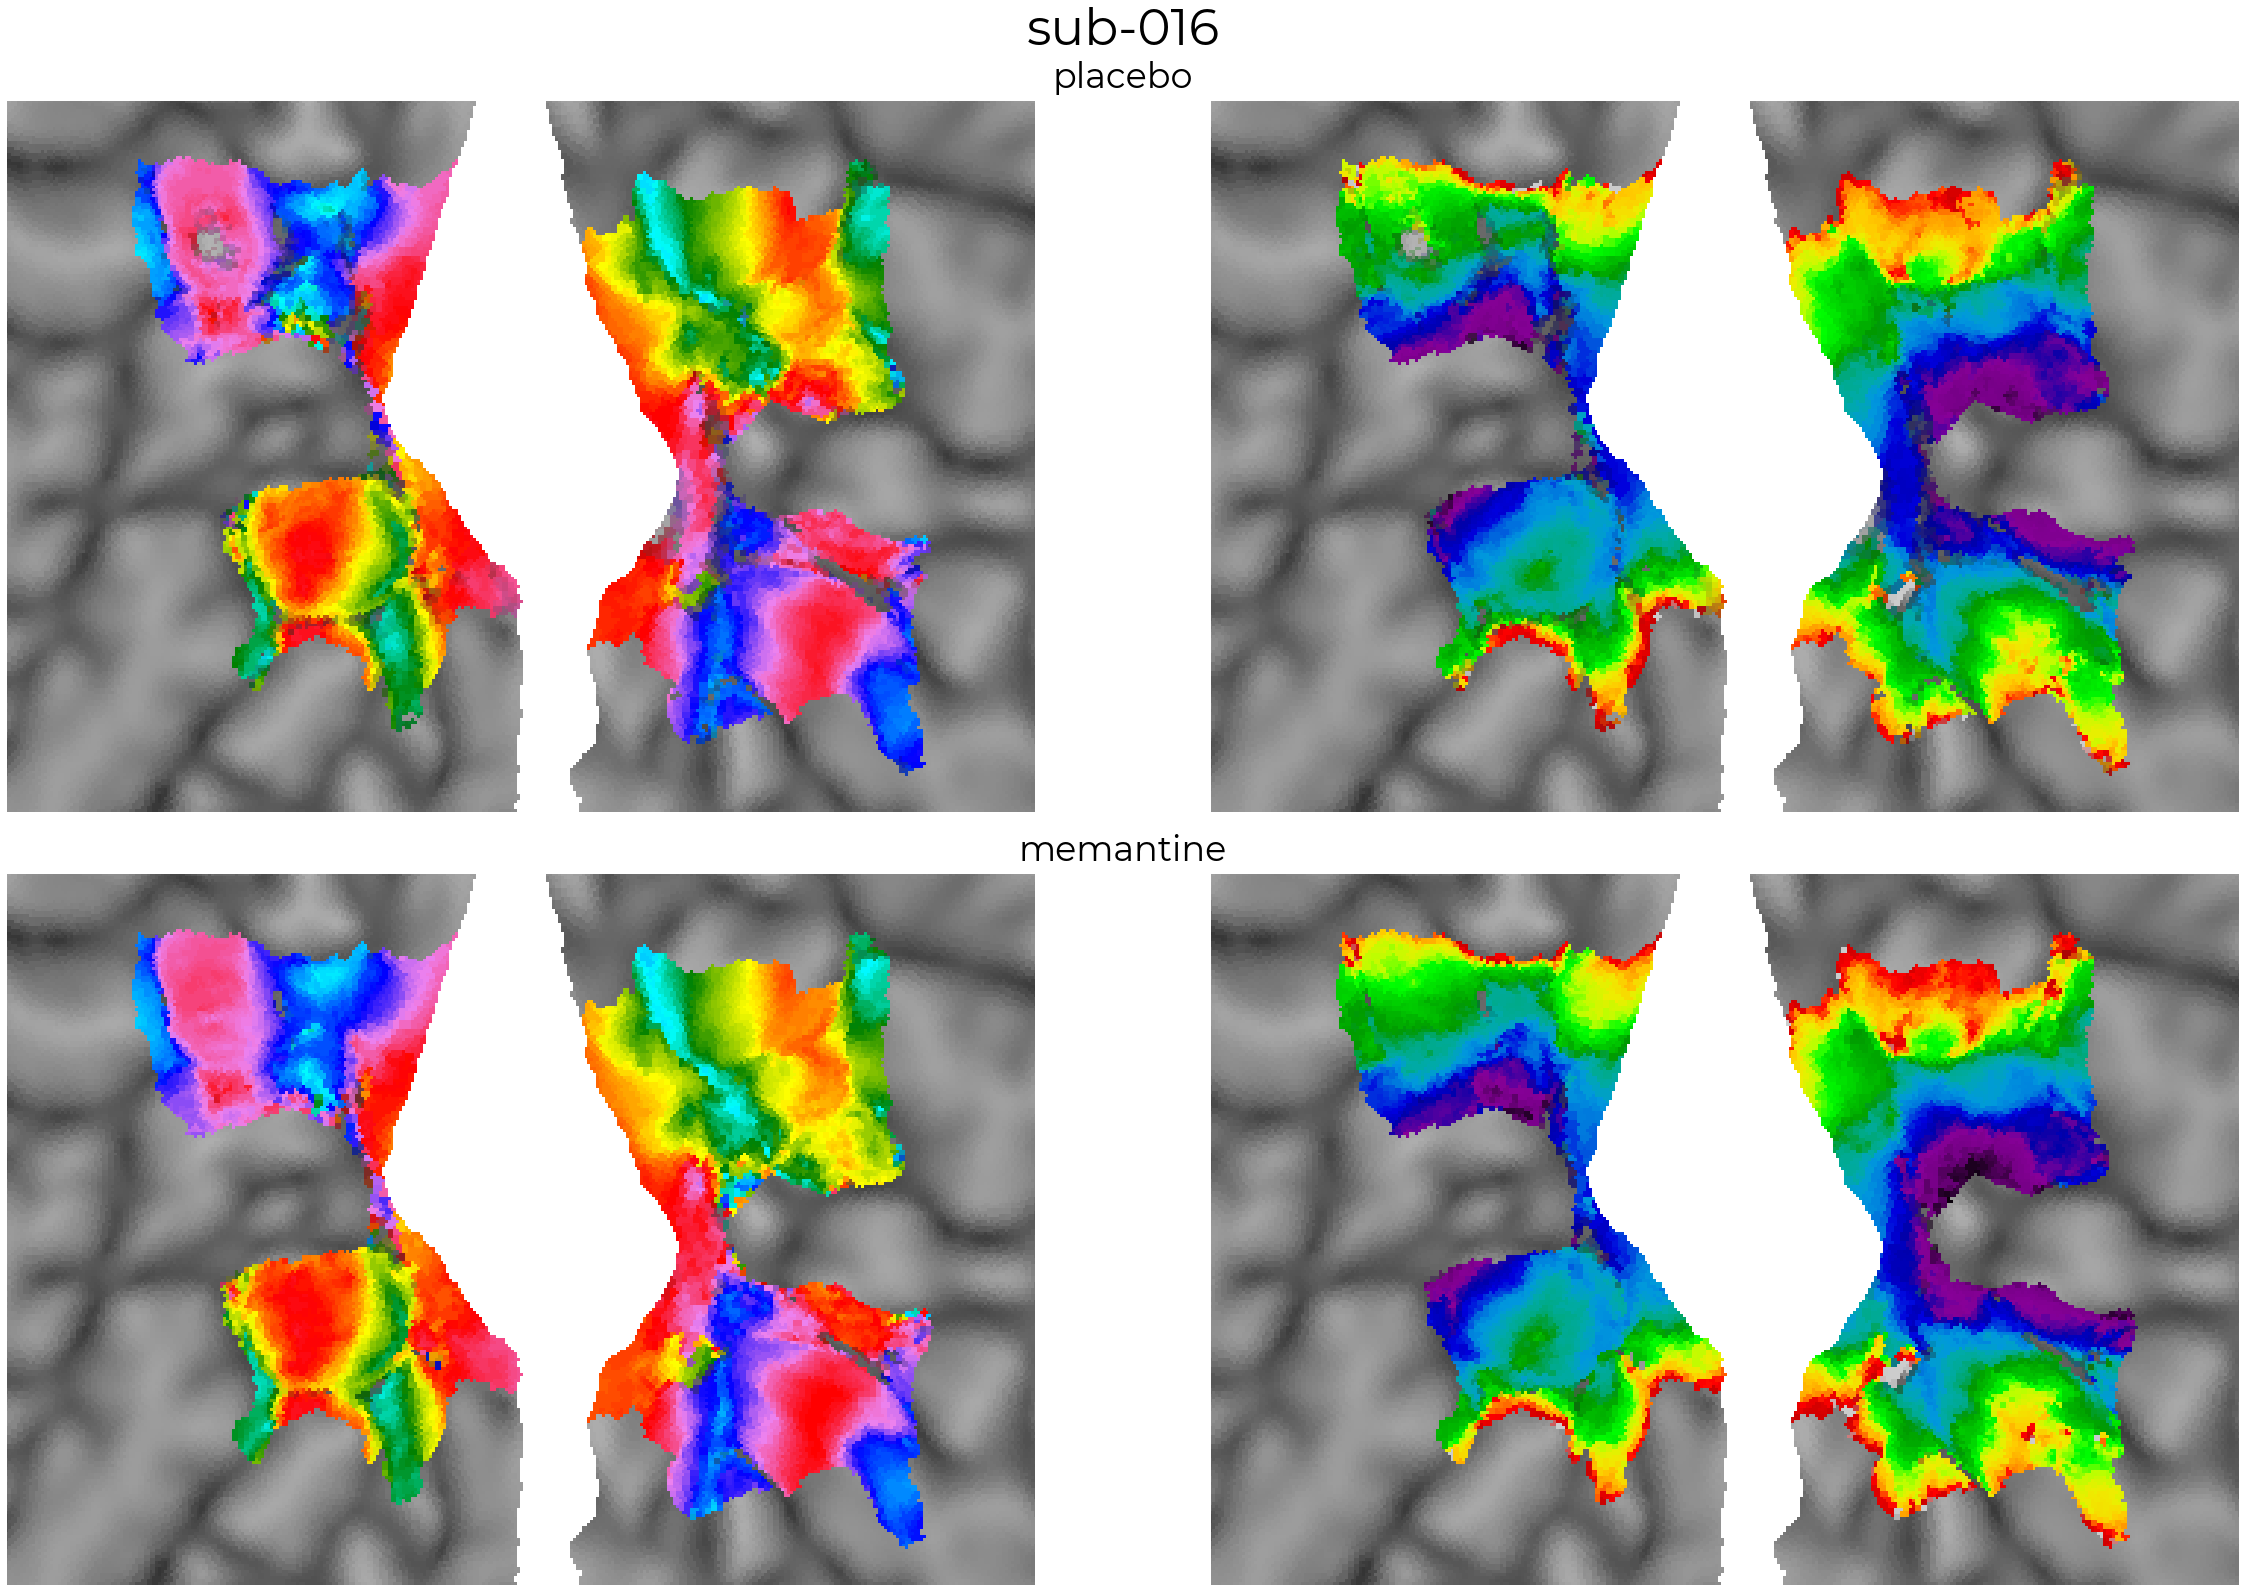

In [246]:
fig = plt.figure(figsize=(33.2,22), constrained_layout=True)
plt.rcParams.update({'font.family': 'Montserrat'})


fig.suptitle(sub, fontsize=50)
subfigures = fig.subfigures(nrows=2, ncols=1)

conditions = ['placebo','memantine']

vertexobjects = [polar_v_plac, ecc_v_plac, polar_v_mem, ecc_v_mem]
index = 0 
# Now loop over the different ROIs (V1/V2/V3)
for row, subfig in enumerate(subfigures):
    axs = subfig.subplots(nrows=1, ncols=2)
    subfig.suptitle(conditions[row], fontsize=35)

    for col in range(2):
        
        cx.quickshow(vertexobjects[index].get_result(), fig=axs[col], with_rois=False, with_colorbar=False)
        axs[col].axis([-65,65,-100,-10])
        index += 1

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/retinotopy/{sub}_retinotopy.png"

plt.savefig(save_path, dpi=300)
plt.show()